# Gensim Movie Tutorial

Python の Gensim ライブラリを使ったチュートリアル https://github.com/RaRe-Technologies/movie-plots-by-genre の練習ノートです。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from smart_open import smart_open
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import random

このチュートリアルの目的は、映画の粗筋からジャンル名を当てる事です。まず素材となるデータを読み込みます。

In [3]:
tagged_plots_movielens = "https://raw.githubusercontent.com/RaRe-Technologies/movie-plots-by-genre/master/data/tagged_plots_movielens.csv"
df = pd.read_csv(smart_open(tagged_plots_movielens)).dropna()
display(df)
print(f'plot: {df.iloc[12]["plot"]}')
print(f'tag: {df.iloc[12]["tag"]}')

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
2443,2443,148618,Three kids who travel back in time to 65 milli...,animation
2444,2444,148624,"Top Cat and the gang face a new police chief, ...",animation
2445,2445,149088,Raggedy Ann and the rest of the toys in Marcel...,animation
2446,2446,149406,"Continuing his ""legendary adventures of awesom...",comedy


plot: In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.
tag: sci-fi


12 行目の内容を抜き出して見ました。plot が粗筋、tag がジャンル名です。これから plot を読んで tag を当てるものを作ります。tag の分布を見てみます。

Comedy / All: 0.32138442521631644


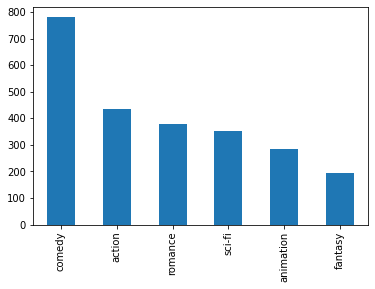

In [4]:
df.tag.value_counts().plot.bar()
print("Comedy / All:", len(df[df.tag=="comedy"]) / len(df))

comedy の tag が突出して多いので、何でもかんでも comedy と予測しただけで 32% の正確性になってしまいます。

sklearn の train_test_split 関数を使って元のデータの9割を教師データとして取り分け、残りの1割をテストデータに取っておきます。ジャンルが偏ってないか一応確認。

Count train: 2184
Count test_data: 243


<AxesSubplot:>

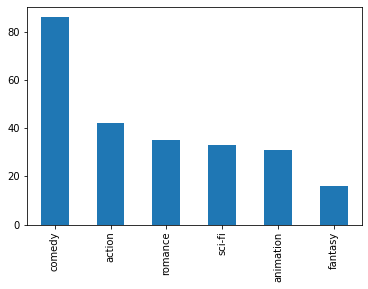

In [5]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
print("Count train:", len(train_data))
print("Count test_data:", len(test_data))
test_data.tag.value_counts().plot.bar()


## Model evaluation approach

これから色々な手法を比較評価していくための枠組みを作ります。

In [6]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    target_names = df.tag.unique()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

ここでは、predict という関数を作って予測器を評価します。predict に3つの引数を与えます。それぞれ

* vectorizer: 文章をベクトルに変換する。
* classifier: ベクトルを使って tag を予測する。
* data: 上で取り分けておいた test_data。

となります。では確認のため最もデタラメな予測器を与えてみましょう。

accuracy 0.35390946502057613
confusion matrix
 [[ 0  0 42  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0 86  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0 35  0  0  0]
 [ 0  0 33  0  0  0]]
(row=expected, col=predicted)


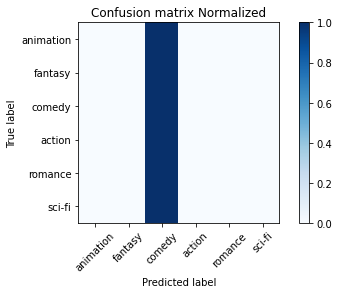

In [7]:
# どんな文章にも [0] を返すベクトル変換器
class Bogus_vectorizer:
    def transform(self, texts):
        return np.zeros((len(texts), 1), int)

# どんな入力にも "comedy" をデタラメに返す予測器
class Bogus_classifier:
    def fit(self, features, tags):
        self.tags = tags.values
    def predict(self, features):
        return np.full(len(features), "comedy")
        #return np.array([random.choice(self.tags) for _ in features]) # こっちの行を有効にするとランダムに返します。

bogus_vectorizer = Bogus_vectorizer()
bogus_vectorizer.transform(test_data["plot"])

bogus_classifier = Bogus_classifier()
bogus_classifier.fit(bogus_vectorizer.transform(train_data["plot"]), train_data["tag"])
bogus_classifier.predict(bogus_vectorizer.transform(test_data["plot"]))

predict(bogus_vectorizer, bogus_classifier, test_data)

Confusion matrix の横軸が予測されたジャンル、縦軸が本当のジャンルです。結果の通り、本当ジャンルに関わらずこのデタラメ予測器は "comedy" と判定しますがそれでも accuracy は 35% 出ます。という事は少なくとも 35% 以上の精度が出ないと頑張った甲斐がないという事になります。

## Bag of words

まず一番簡単な Bag of words と LogisticRegression を試します。Bag of worlds とは、単語の出現頻度を数えて文の特徴ベクトルとする物です。例えば "bye bye now" なら bye: 2, now: 1 のようなベクトルになります。出来た特徴ベクトルが出来ると、教師データで LogisticRegression を訓練して予測器を作ります。

ここでは sklearn の CountVectorizer を使います。文章を単語ごとに区切る tokenizer を内蔵している優れものです。数える単語の数を上位頻出 3000 語に限ります。

In [8]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word",
    stop_words='english',
    max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])
train_data_features

CPU times: user 100 ms, sys: 2.38 ms, total: 103 ms
Wall time: 102 ms


<2184x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 49189 stored elements in Compressed Sparse Row format>

train_data_features は粗筋の数 x 単語の数 (最大 3000) の表で、単語が何件出現するかを記録したものです。

試しに教師データの粗筋がどのように変換されたか見てみます。CountVectorizer はレアすぎる単語や頻繁すぎる単語は除外してくれるので、それなりに文章の特徴を表す単語がカウントされています。

In [9]:
def show_count(index):
    print("plot:", train_data.iloc[index]["plot"])
    print("count:")
    print({
        count_vectorizer.get_feature_names()[key]: train_data_features[index, key]
            for key
            in train_data_features[index].indices})
          
show_count(12)

plot: A bumbling professor accidently invents flying rubber, or "Flubber", an incredible material that gains energy every time it strikes a hard surface. It allows for the invention of shoes that can allow jumps of amazing heights and enables a modified Model-T to fly. Unfortunately, no one is interested in the material except for Alonzo Hawk, a corrupt businessman who wants to steal the material for himself.
count:
{'wants': 1, 'hard': 1, 'corrupt': 1, 'unfortunately': 1, 'bumbling': 1, 'professor': 1, 'flying': 1, 'incredible': 1, 'material': 3, 'gains': 1, 'energy': 1, 'time': 1, 'strikes': 1, 'surface': 1, 'allows': 1, 'invention': 1, 'shoes': 1, 'allow': 1, 'amazing': 1, 'heights': 1, 'model': 1, 'fly': 1, 'interested': 1, 'hawk': 1, 'businessman': 1, 'steal': 1}


得られた Bag of words を特徴ベクトルとして、LogisticRegression でジャンルの予測器を作ってみます。

accuracy 0.4444444444444444
confusion matrix
 [[23  2 10  0  4  3]
 [ 2 11  8  2  3  5]
 [12  8 45  2 17  2]
 [ 3  2  2  3  5  1]
 [ 3  4 12  1 14  1]
 [ 9  4  6  2  0 12]]
(row=expected, col=predicted)


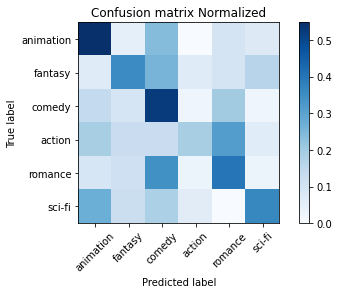

In [10]:
logreg = linear_model.LogisticRegression(n_jobs=-1, C=1e5)
logreg.fit(train_data_features, train_data['tag'])

predict(count_vectorizer, logreg, test_data)

テストデータを使って評価すると、44% とまあまあ良い正答率です。特に amination や comedy の成績が良いです。

LogisticRegression の coef_ 属性を使うと、どのベクトルの次元の影響力が強いのか観察出来ます。coef_ は tag の数 x 特徴ベクトルの次元(単語の数) で、数字が大きいほど影響力が大きいです。

In [11]:
for tag_index, tag in enumerate(logreg.classes_):
    print(f"{tag}: {logreg.coef_[tag_index]})")

action: [ 0.75573721 -0.47581172  0.54842262 ... -1.99314501 -0.2582481
 -0.09286177])
animation: [-0.50553718  1.19642655 -0.12130582 ... -0.68777642 -0.11919812
  0.69879877])
comedy: [-0.03884728  1.97907157  0.74785816 ...  5.12966293 -1.77318799
 -0.08446958])
fantasy: [-0.62133302 -0.01795021 -0.63881266 ... -0.42830753 -1.0628616
 -0.05787423])
romance: [-0.98587051 -2.00795811 -0.30017212 ... -0.37590957  1.07365758
 -0.35639341])
sci-fi: [ 1.39585078 -0.67377808 -0.23599017 ... -1.64452441  2.13983822
 -0.10719979])


coef_ をソートしてジャンルを特徴づける単語を確認します。割と納得の結果なのではと思います。

In [12]:
def most_influential_words(vectorizer, classifier, num_words=10):
    words = vectorizer.get_feature_names()
    for tag_index, tag in enumerate(classifier.classes_):
        coef = classifier.coef_[tag_index]
        sorted_coef = sorted(enumerate(coef), key=lambda x:x[1], reverse=True)
        sorted_word = [words[index] for index, value in sorted_coef]
        print(f"{tag}: {sorted_word[:num_words]})")    
        
most_influential_words(count_vectorizer, logreg, 5)

action: ['america', 'assassin', 'conspiracy', 'pursue', 'terrorists'])
animation: ['forest', 'fight', 'snow', 'ending', 'adventurous'])
comedy: ['mistaken', 'comedy', 'dealer', 'actress', 'comedian'])
fantasy: ['national', 'princess', 'dragon', 'kingdom', 'beast'])
romance: ['decide', 'relationships', 'troubled', 'beth', 'nazi'])
sci-fi: ['future', 'futuristic', 'cube', 'enterprise', 'space'])


## Character N-grams

次は N-grams です。N-grams というのは、単語で区切る事すらせずに、前後 n 個の文字列の頻度を数えて特徴量とする物です。乱暴なようですが、意外とそれなりの結果が出ます。ここでは 2 から 5 までの文字を区切って特徴量を作ります。

In [13]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 2min 15s, sys: 29.1 s, total: 2min 44s
Wall time: 13.1 s


accuracy 0.3950617283950617
confusion matrix
 [[17  3 10  1  9  2]
 [ 5  9  9  3  1  4]
 [15  8 41  4 16  2]
 [ 2  2  3  3  2  4]
 [ 5  1 14  1 13  1]
 [ 9  1  5  4  1 13]]
(row=expected, col=predicted)


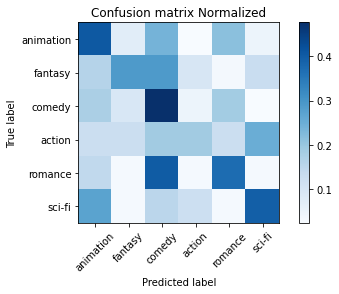

In [14]:
predict(n_gram_vectorizer, logreg, test_data)

In [15]:
most_influential_words(n_gram_vectorizer, logreg, 5)

action: ['my', ' war', 'ank', 'es ', 'ist '])
animation: [' an', 'oy', 'ot', 'y d', 'ima'])
comedy: ['ks', 'ud', 'per', 'ate', 'man '])
fantasy: ['au', 'king', 'rag', 'd of ', 't d'])
romance: ['so', 'vel', ' love', 'par', 'ili'])
sci-fi: ['fu', 'rg', 'ar ', ' a f', ' fu'])


影響力の大きい特徴量を見ると、まあそんなもんかなと思います。